## https://drive.google.com/file/d/1mq_qWNMgd8COoUorWr819MMyy_mB7rr7/view?usp=sharing

## **Importing Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# 📥 Load Dataset
df = pd.read_csv('/content/data_news - data_news (1).csv')

## EDA

In [ ]:
df.head()

In [3]:
# 🔍 Basic EDA
print("Dataset shape:", df.shape)

Dataset shape: (50000, 5)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [5]:
df['category'].value_counts()


category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64

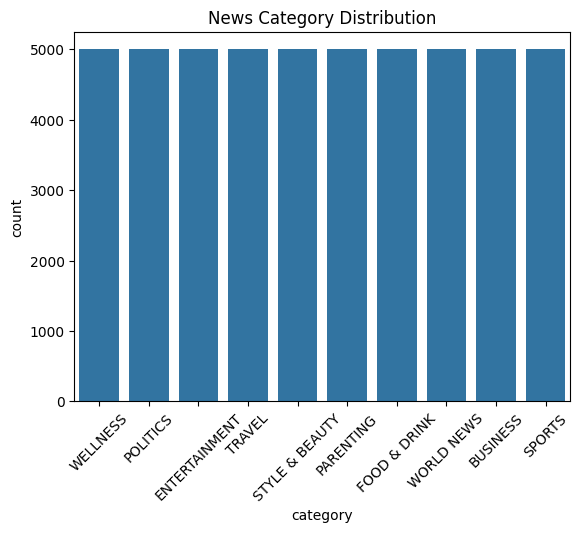

In [6]:
sns.countplot(data=df, x='category')
plt.title('News Category Distribution')
plt.xticks(rotation=45)
plt.show()

In [7]:
# 🧹 Text Cleaning and Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    return text

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [9]:
def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [20]:
df['headline'] = df['headline'].apply(clean_text)
df['short_description'] = df['short_description'].apply(clean_text)

df.dropna(subset=['category', 'headline', 'short_description'], inplace=True)

df['text'] = df['headline'] + ' ' + df['short_description']


In [21]:
# Apply Preprocessing
df['clean_text'] = df['short_description'].astype(str).apply(preprocess_text)

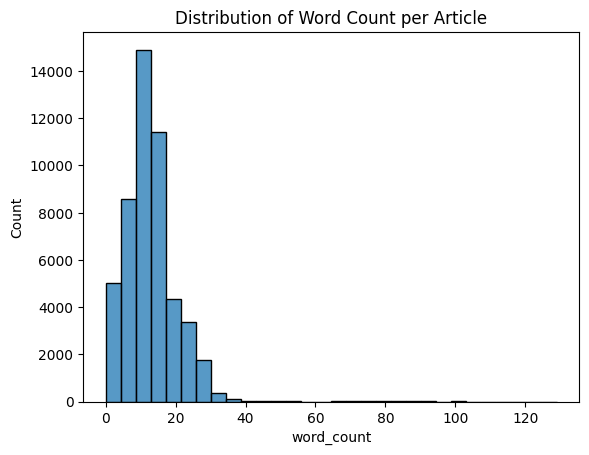

In [22]:
# 📊 Word Count Histogram
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'], bins=30)
plt.title('Distribution of Word Count per Article')
plt.show()

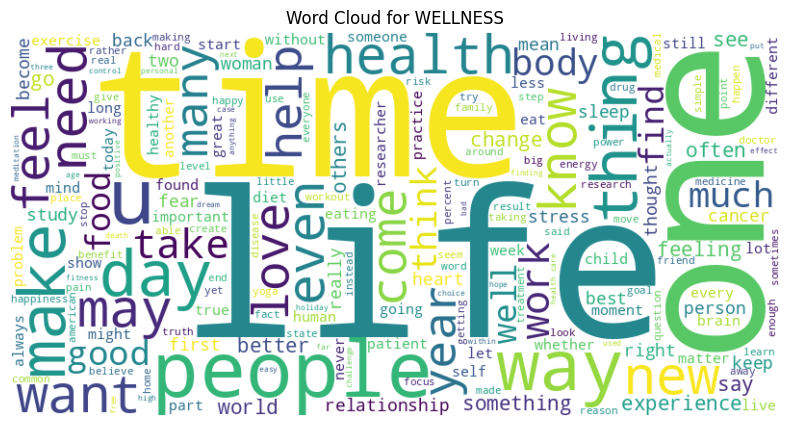

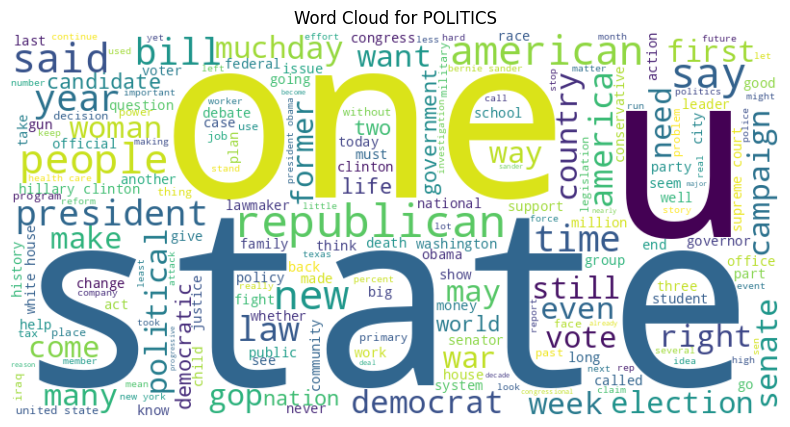

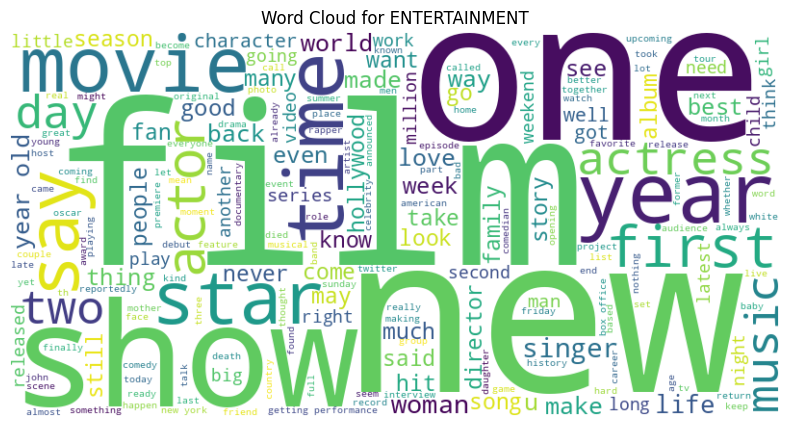

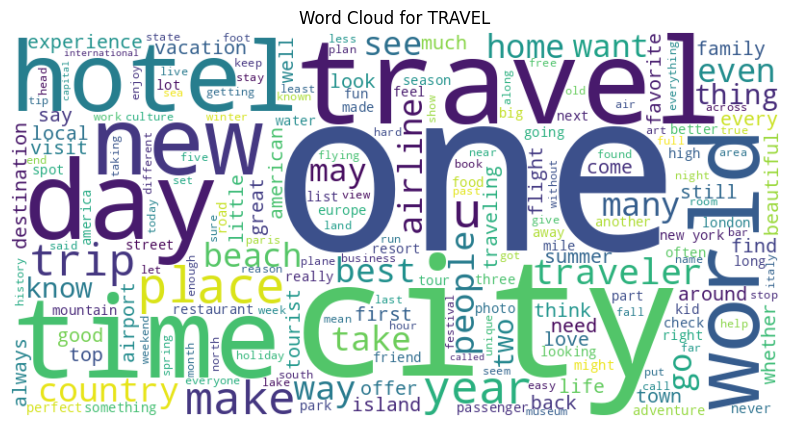

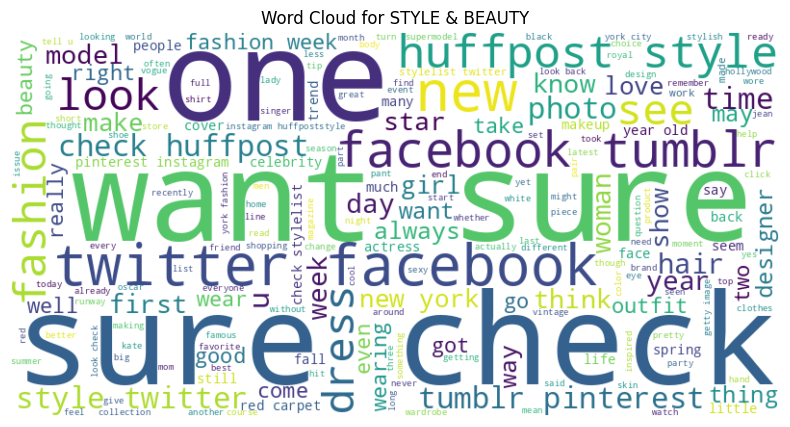

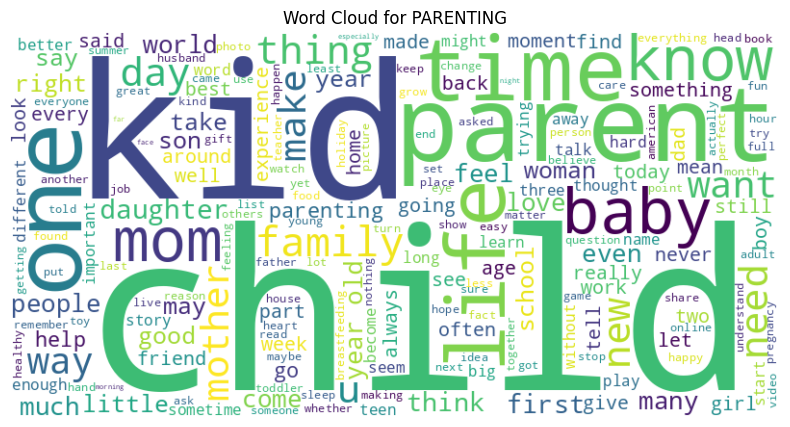

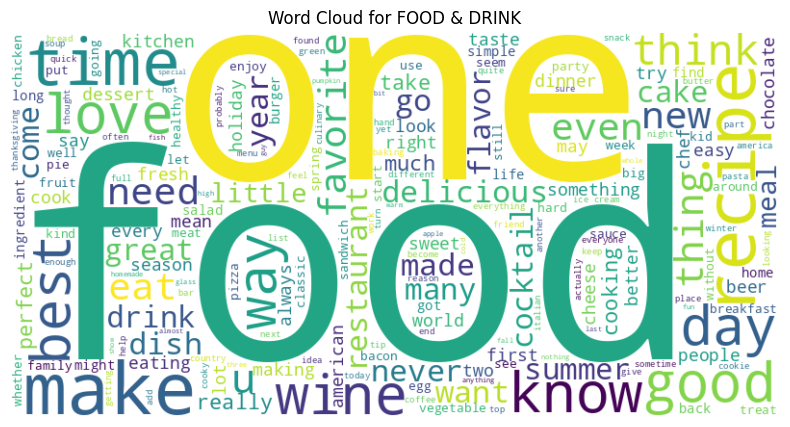

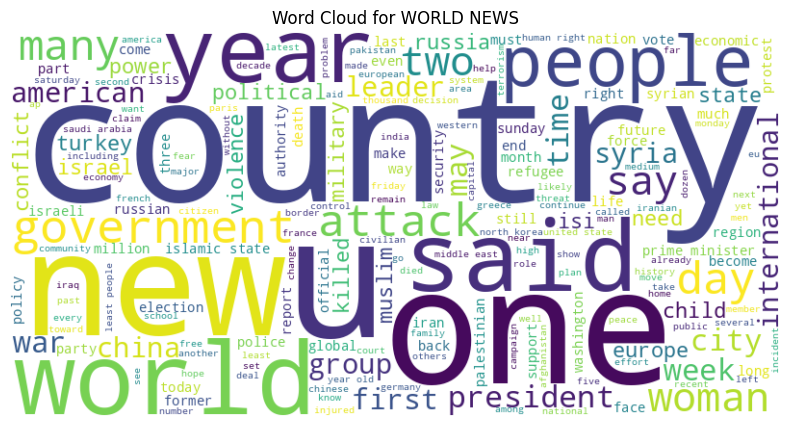

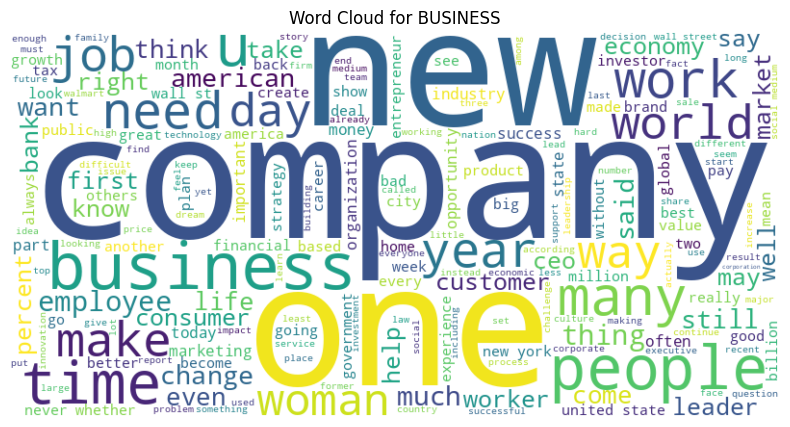

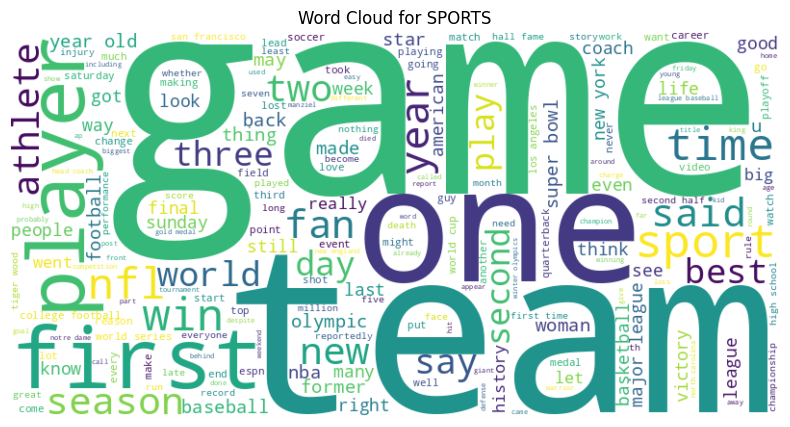

In [23]:
# ☁️ Word Clouds by Category
categories = df['category'].unique()
for category in categories:
    text = ' '.join(df[df['category'] == category]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()

In [24]:
# 🔠 TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_text'])
y = df['category']

In [25]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
# 🔍 Hyperparameter Tuning for All Models
# Logistic Regression
lr_params = {'C': [0.1, 1, 10]}
gs_lr = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3)
gs_lr.fit(X_train, y_train)
print("Best Logistic Regression Params:", gs_lr.best_params_)

Best Logistic Regression Params: {'C': 1}


In [16]:
# Naive Bayes
nb_params = {'alpha': [0.01, 0.1, 1]}
gs_nb = GridSearchCV(MultinomialNB(), nb_params, cv=3)
gs_nb.fit(X_train, y_train)
print("Best Naive Bayes Params:", gs_nb.best_params_)

Best Naive Bayes Params: {'alpha': 1}


In [17]:
# SVM
svm_params = {'C': [0.1, 1, 10]}
gs_svm = GridSearchCV(SVC(kernel='linear', probability=True), svm_params, cv=3)
gs_svm.fit(X_train, y_train)
print("Best SVM Params:", gs_svm.best_params_)

Best SVM Params: {'C': 1}


In [28]:
# 📊 Model Evaluation Function
def evaluate_model(model, name):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve (for binary classification)
    if len(np.unique(y)) == 2:
        fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=np.unique(y_test)[1])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, probs[:, 1]):.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.grid(True)
        plt.show()



Tuned Logistic Regression Accuracy: 0.6574
                precision    recall  f1-score   support

      BUSINESS       0.66      0.65      0.66      1000
 ENTERTAINMENT       0.54      0.57      0.55      1000
  FOOD & DRINK       0.66      0.74      0.70      1000
     PARENTING       0.67      0.64      0.66      1000
      POLITICS       0.65      0.59      0.62      1000
        SPORTS       0.67      0.69      0.68      1000
STYLE & BEAUTY       0.73      0.70      0.72      1000
        TRAVEL       0.69      0.65      0.67      1000
      WELLNESS       0.62      0.67      0.64      1000
    WORLD NEWS       0.69      0.66      0.67      1000

      accuracy                           0.66     10000
     macro avg       0.66      0.66      0.66     10000
  weighted avg       0.66      0.66      0.66     10000



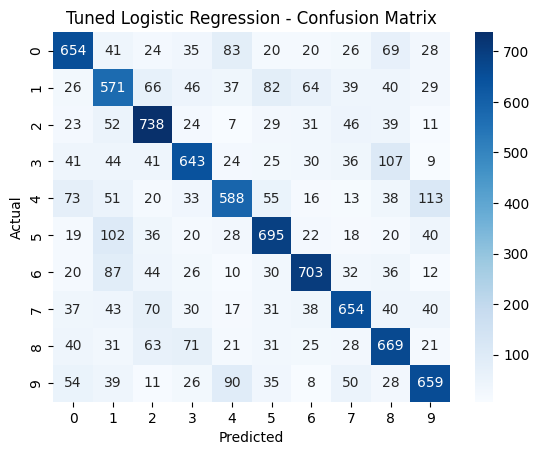


Tuned Multinomial Naive Bayes Accuracy: 0.6355
                precision    recall  f1-score   support

      BUSINESS       0.60      0.61      0.60      1000
 ENTERTAINMENT       0.59      0.52      0.55      1000
  FOOD & DRINK       0.65      0.75      0.70      1000
     PARENTING       0.54      0.66      0.59      1000
      POLITICS       0.65      0.57      0.61      1000
        SPORTS       0.74      0.62      0.68      1000
STYLE & BEAUTY       0.73      0.66      0.69      1000
        TRAVEL       0.65      0.65      0.65      1000
      WELLNESS       0.57      0.65      0.61      1000
    WORLD NEWS       0.68      0.67      0.68      1000

      accuracy                           0.64     10000
     macro avg       0.64      0.64      0.64     10000
  weighted avg       0.64      0.64      0.64     10000



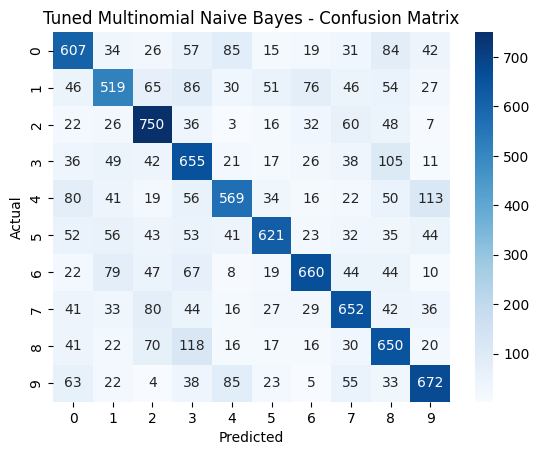


Tuned Support Vector Machine Accuracy: 0.6509
                precision    recall  f1-score   support

      BUSINESS       0.65      0.68      0.66      1000
 ENTERTAINMENT       0.49      0.60      0.54      1000
  FOOD & DRINK       0.64      0.74      0.69      1000
     PARENTING       0.67      0.62      0.64      1000
      POLITICS       0.62      0.58      0.60      1000
        SPORTS       0.71      0.71      0.71      1000
STYLE & BEAUTY       0.74      0.67      0.70      1000
        TRAVEL       0.72      0.62      0.67      1000
      WELLNESS       0.63      0.65      0.64      1000
    WORLD NEWS       0.70      0.65      0.67      1000

      accuracy                           0.65     10000
     macro avg       0.66      0.65      0.65     10000
  weighted avg       0.66      0.65      0.65     10000



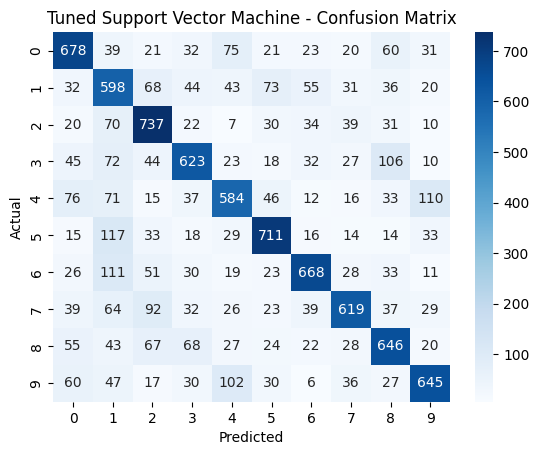

In [29]:
# 📋 Evaluate All Tuned Models
evaluate_model(gs_lr.best_estimator_, "Tuned Logistic Regression")
evaluate_model(gs_nb.best_estimator_, "Tuned Multinomial Naive Bayes")
evaluate_model(gs_svm.best_estimator_, "Tuned Support Vector Machine")

In [27]:
# 💡 Most Informative Words (Logistic Regression)
feature_names = vectorizer.get_feature_names_out()
coefs = gs_lr.best_estimator_.coef_
if coefs.shape[0] == 1:
    top_pos = np.argsort(coefs[0])[-10:]
    top_neg = np.argsort(coefs[0])[:10]
    print("Top Positive Words:")
    print([feature_names[i] for i in top_pos])
    print("Top Negative Words:")
    print([feature_names[i] for i in top_neg])
else:
    for i, cat in enumerate(gs_lr.best_estimator_.classes_):
        top_features = np.argsort(coefs[i])[-10:]
        print(f"\nTop words for class {cat}:")
        print([feature_names[j] for j in top_features])


Top words for class BUSINESS:
['economy', 'walmart', 'customer', 'leadership', 'financial', 'employee', 'ceo', 'bank', 'business', 'company']

Top words for class ENTERTAINMENT:
['jenner', 'comedian', 'star', 'actress', 'music', 'movie', 'actor', 'album', 'singer', 'film']

Top words for class FOOD & DRINK:
['cake', 'flavor', 'kitchen', 'cooking', 'chef', 'cheese', 'cocktail', 'wine', 'food', 'recipe']

Top words for class PARENTING:
['family', 'son', 'toddler', 'daughter', 'parenting', 'baby', 'mom', 'parent', 'kid', 'child']

Top words for class POLITICS:
['political', 'president', 'democratic', 'senate', 'democrat', 'senator', 'clinton', 'state', 'gop', 'republican']

Top words for class SPORTS:
['quarterback', 'coach', 'nba', 'league', 'team', 'athlete', 'game', 'sport', 'player', 'nfl']

Top words for class STYLE & BEAUTY:
['makeup', 'outfit', 'designer', 'kate', 'beauty', 'model', 'hair', 'dress', 'style', 'fashion']

Top words for class TRAVEL:
['tsa', 'tourist', 'flight', 'tra

In [ ]:

# ✅ Summary
print("""
Summary:
- Text cleaned with stopword removal and lemmatization.
- TF-IDF vectorization with bigrams and 5000 features.
- Tuned Logistic Regression, Naive Bayes, and SVM with GridSearchCV.
- Evaluated using classification report, confusion matrix, ROC curves.
- Top keywords per category identified using model coefficients.
""")
